# Calibration of the XY-axes in a laser scanning microscope

In this notebook, we present the procedure to calibrate the XY scanner (e.g., galvo mirrors) of a microscope. We used a reflective [grid array](https://www.thorlabs.com/thorproduct.cfm?partnumber=R1L3S3PR) sample from Thorlabs. The reference grid we used are is the one with spacing Δx = 10 µm.

In [1]:
import numpy as np
import numpy.fft as ft
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

import brighteyes_ism.dataio.mcs as mcs
import brighteyes_ism.analysis.Tools_lib as tool
import brighteyes_ism.analysis.Graph_lib as gr

import os

## Data loading
In this case, the data are stored as an hdf5 file generated by the [BrightEyes-MCS](https://github.com/VicidominiLab/BrightEyes-MCS) software.

In [2]:
path = r'\\iitfsvge101.iit.local\mms\Data MMS server\STED-ISM\SetupDiagnostics\calibrations\grid\10um\B'

for file in sorted( os.listdir(path) ):
    if file.endswith('.h5'):
        print(file)
        break

fullpath = os.path.join(path, file)
data, meta = mcs.load(fullpath)

data-25-10-2022-18-33-54.h5


To perform the acquisition, we used a 640 nm CW laser.<br>
The microscope is a custom ISM setup, equipped with a 60x/1.4 oil objective lens.<br>
The detector array size is 1.4 Airy Units.<br>
We print the metadata, to show the acquisition parameters.

In [3]:
meta.Print()

version       0.0.1
comment       
rangex        100.0
rangey        100.0
rangez        0.0
nbin          10
dt            5.0
nx            2000
ny            2000
nz            1
nrep          1
calib_x       17.303
calib_y       17.409
calib_z       10.0


The ISM data structure is (repetition, z, y, x, time, channel). <br>
Since we are not interested in having high-resolution and the sample is flat, we keep only the spatial dimensions (y, x).

In [4]:
img = np.sum(data, axis = (0,1,4,5))

We have a look at the image of the grid.

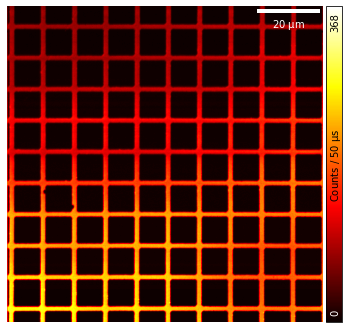

In [5]:
fig, ax = plt.subplots(1,1, figsize = (6,6))
fig, ax = gr.ShowImg(img, meta.dx, clabel = meta.pxdwelltime, fig = fig, ax = ax)

## Calculation of the reciprocal lattice

We calculate the absolute value of the Fourier transform of the image.

In [6]:
f_ax = ft.fftshift( ft.fftfreq(meta.nx) )
imgF = ft.fftshift( ft.fft2(img) )
F = np.abs(imgF)

## Measurement of the harmonics coordinates

We measure the positions of the peaks of the reciprocal lattice.

In [7]:
idx_max = np.unravel_index(np.argmax(F), np.array(F).shape)
peak_idx = peak_local_max(F, threshold_rel = 0.2)

We have a look at the grid in the frequency space. <br>
We highlight the positions of the peaks with a marker.

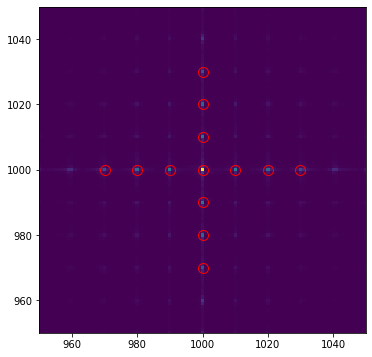

In [8]:
plt.figure(figsize = (6,6))
plt.imshow(F)
plt.xlim( [950,1050] )
plt.ylim( [950,1050] )
plt.plot(peak_idx[:,0], peak_idx[:,1], 'ro', markersize = 10, markerfacecolor='none')

We change the reference frame of the coordinates, such that they are relative to the zero-order position.

In [9]:
rel_peak = peak_idx - idx_max

We select the first harmonic on each axis and calculate the corresponding period in space.

In [10]:
peak_x = np.abs( rel_peak[:,0] )
peak_y = np.abs( rel_peak[:,1] )

dfx = 1 / meta.nx
dfy = 1 / meta.ny

X = 1 / ( np.min( peak_x[np.nonzero(peak_x)] ) * dfx ) # pixel
Y = 1 / ( np.min( peak_y[np.nonzero(peak_y)] ) * dfy ) # pixel

## Calibration

Knowing the real spacing of the grid, we can calculate how many pixel fit in the period of the grid.

In [11]:
T = 10 # um

px_x = T / X # um / px
px_y = T / Y # um / px

Lastly, we convert the pixels into volts to find the calibration values.

In [12]:
calib_x = px_x * meta.calib_x / meta.dx
calib_y = px_y * meta.calib_y / meta.dy

print(f'calib_x = {calib_x} um/V')
print(f'calib_y = {calib_y} um/V')

calib_x = 17.303 um/V
calib_y = 17.409 um/V
